# Global Annual Mean of SST, SSS, magnitude of density gradient
## Table Of Contents: <a class="anchor" id="top"> </a>
* [SST](#first-bullet)
* [SSS](#second-bullet)
* [$\frac{\nabla \rho}{|\nabla \rho|}$](#third-bullet)

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import pop_tools
import gcsfs
import fastjmd95

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
cesm  = cat["CESM_POP_hires_control"].to_dask()
#workaround from Julius to make gradient func work quicker
ds_drop = cesm.drop([v for v in cesm.coords if v not in ['DXT', 'DXU', 'DYT', 'DYU',
                                                         'nlat', 'nlon', 'time']])

In [3]:
ds = ds_drop.isel(time=slice(0,180))

In [4]:
ds

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, time: 180)
Coordinates:
    DXT      (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU      (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT      (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU      (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
  * time     (time) object 0046-01-02 00:00:00 ... 0046-06-30 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    HMXL_2   (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SFWF_2   (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SHF_2    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSH_2    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSS      (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST      (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TAUX_2   (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TAUY_2   (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U1_1     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U2_2     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    V1_1     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    V2_2     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    calendar:      All years have exactly  365 days.
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    contents:      Diagnostic and Prognostic Variables
    history:       none
    nsteps_total:  13088337
    revision:      $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy@ucar.edu $
    source:        CCSM POP2, the CCSM Ocean Component
    start_time:    This dataset was created on 2013-03-09 at 12:25:55.7
    tavg_sum:      86399.99999999962
    title:         hybrid_v5_rel04_BC5_ne120_t12_pop62

In [5]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [6]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/staging.66d0db0cb92348d3b7305e473627617f/status,


In [33]:
client.close()
cluster.close()

# 1) SST <a class='anchor' id='first-bullet'> </a>

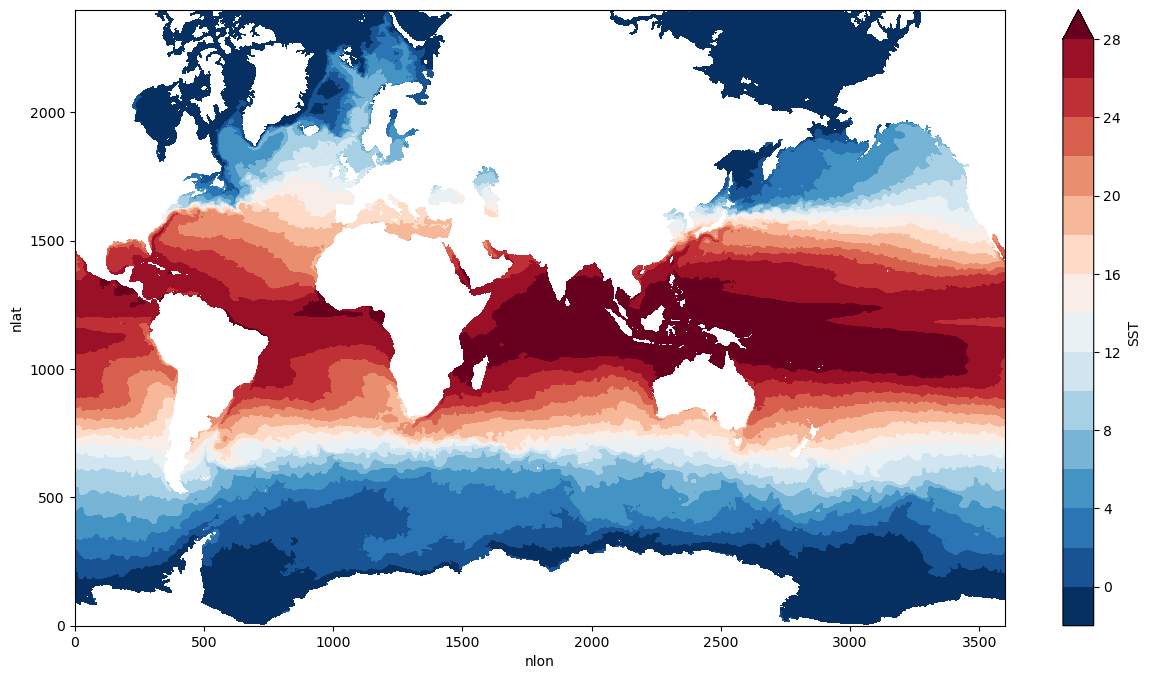

In [20]:
#global turner angle
fig, ax = plt.subplots(figsize=(15,8))
ds.SST.mean('time').plot.contourf(levels=np.arange(-2, 30, 2),ax=ax);

# 2) SSS <a class='anchor' id='second-bullet'> </a>

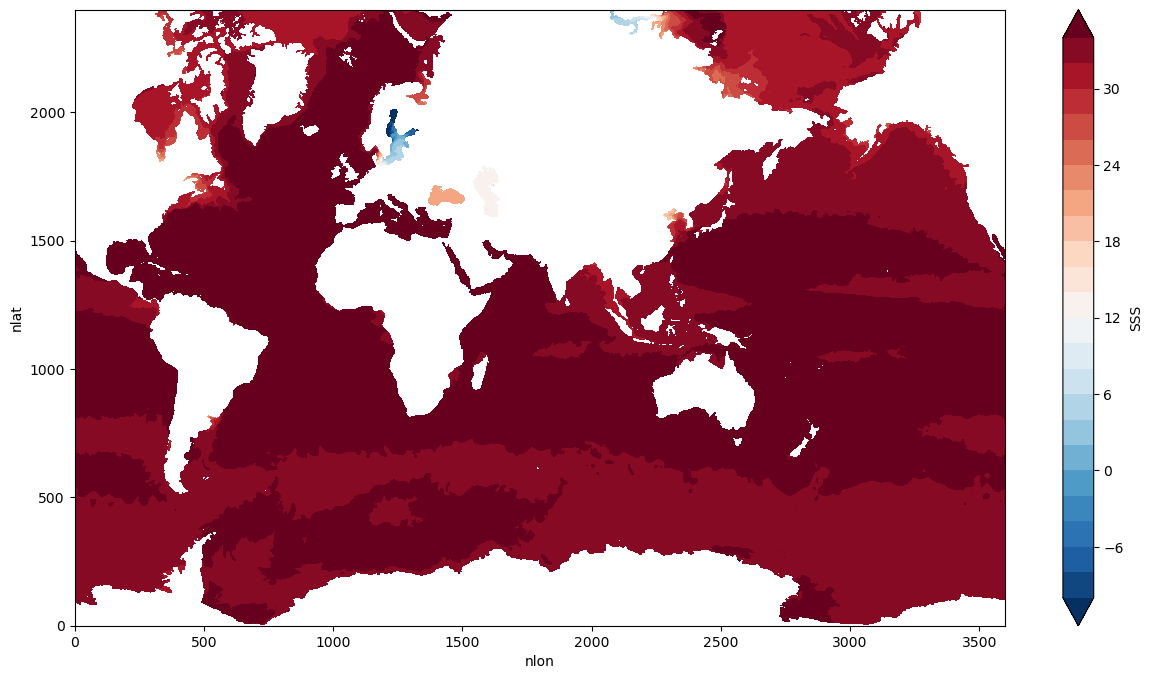

In [27]:
#global turner angle
fig, ax = plt.subplots(figsize=(15,8))
ds.SSS.mean('time').plot.contourf(levels=np.arange(-10, 35, 2),robust=True, ax=ax);

# 3) $\frac{\nabla \rho}{|\nabla \rho|}$ <a class='anchor' id='third-bullet'> </a>

In [7]:
grid, ds_ren = pop_tools.to_xgcm_grid_dataset(ds)

def gradient(da):
    """Compute the gradients of T, S and rho"""

    da_diffx = grid.diff(da, 'X')
    da_diffy = grid.diff(da, 'Y', boundary='fill')
    da_diffx_interp = grid.interp(da_diffx, 'X')
    da_diffy_interp = grid.interp(da_diffy, 'Y', boundary='fill')
    dadx = da_diffx_interp/ds_ren.DXT
    dady = da_diffy_interp / ds_ren.DYT
    return dadx, dady

In [18]:
#magnitude of density gradient
rho = fastjmd95.rho(ds_ren.SSS, ds_ren.SST, 0)

gradrho = gradient(rho)
modgradrho = np.sqrt(gradrho[0]**2 + gradrho[-1]**2)

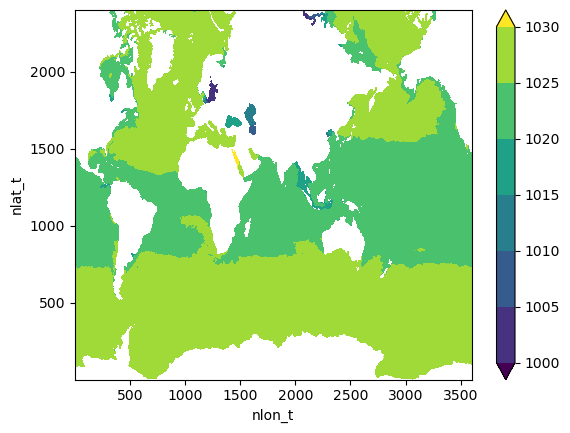

In [9]:
rho.mean('time').plot.contourf(levels=np.arange(1000, 1035, 5))

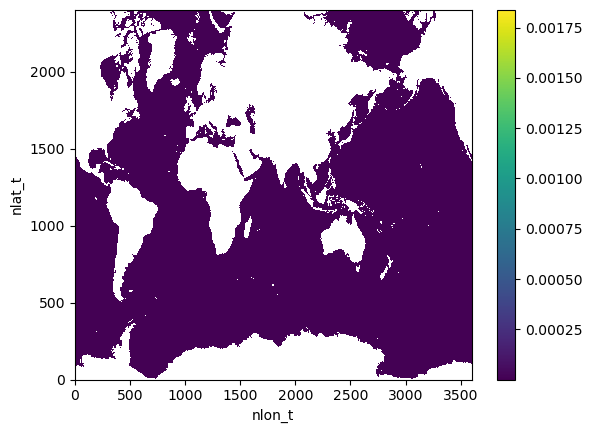

In [20]:
modgradrho.mean('time').plot()

In [23]:
from matplotlib.colors import LogNorm

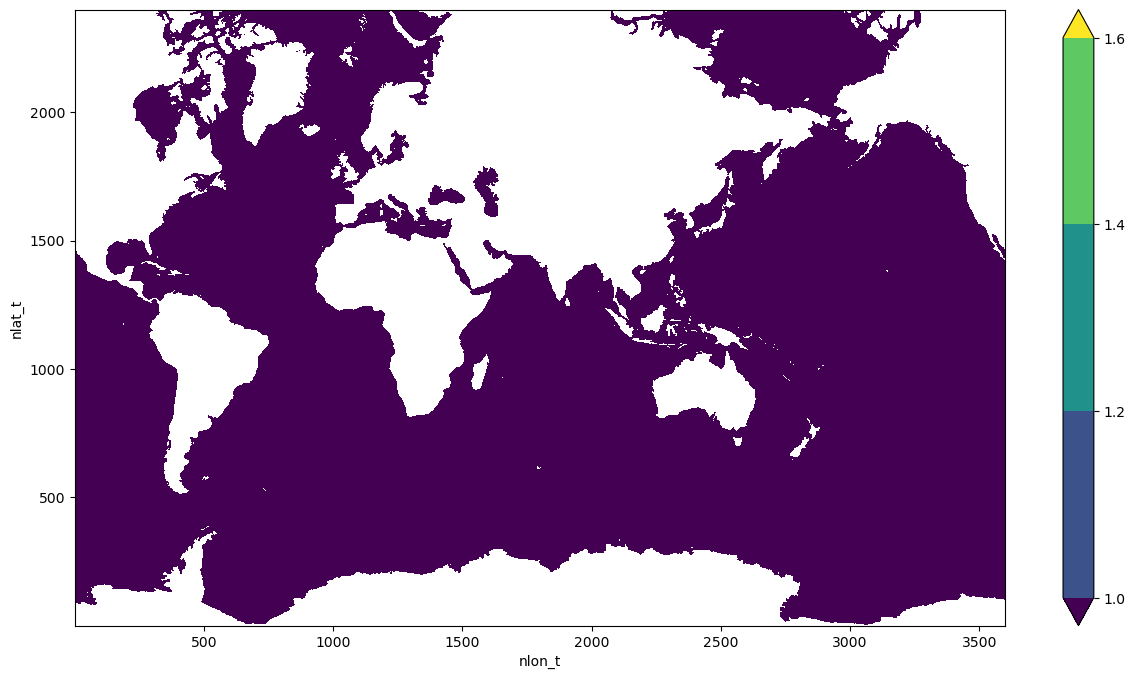

In [29]:
#global magnitude of density gradient
fig, ax = plt.subplots(figsize=(15,8))
(modgradrho*1e3).mean('time').plot.contourf(levels=np.arange(1, 1.8, 0.2),robust=True, ax=ax);

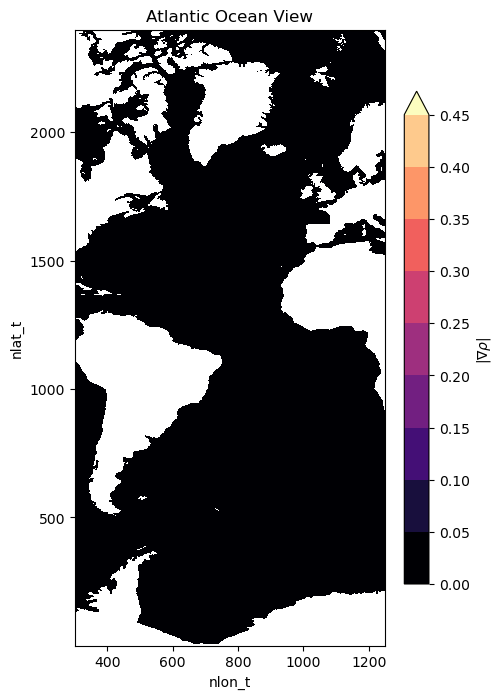

In [34]:
#ATL ocean
fig, ax = plt.subplots(figsize=(5,8))
(modgradrho*1e3).isel(nlon_t=slice(300,1250)).mean('time').plot.contourf(levels=np.arange(0, 0.5, 0.05), 
                                                                         cmap='magma',
                                                                         cbar_kwargs={'shrink':0.8, 
                                                                         'label':r'$|\nabla \rho|$'})
plt.title('Atlantic Ocean View');

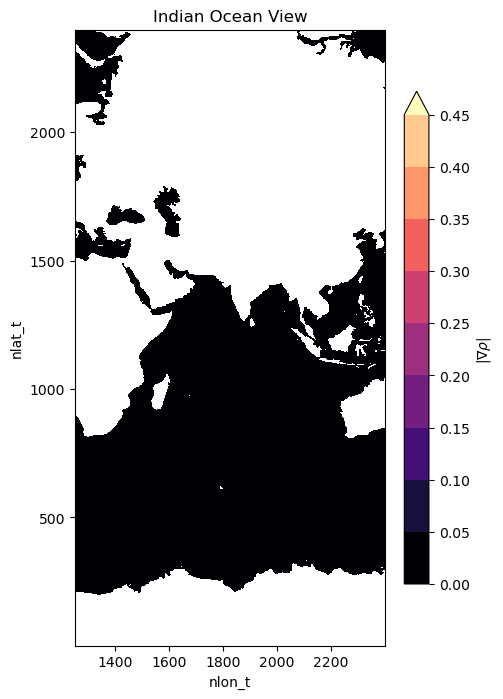

In [38]:
#IND ocean
fig, ax = plt.subplots(figsize=(5,8))
(modgradrho*1e3).isel(nlon_t=slice(1250, 2400)).mean('time').plot.contourf(levels=np.arange(0, 0.5, 0.05), 
                                                                  cmap='magma',
                                                                  cbar_kwargs={'shrink':0.8, 
                                                                               'label':r'$|\nabla \rho|$'})
plt.title('Indian Ocean View');

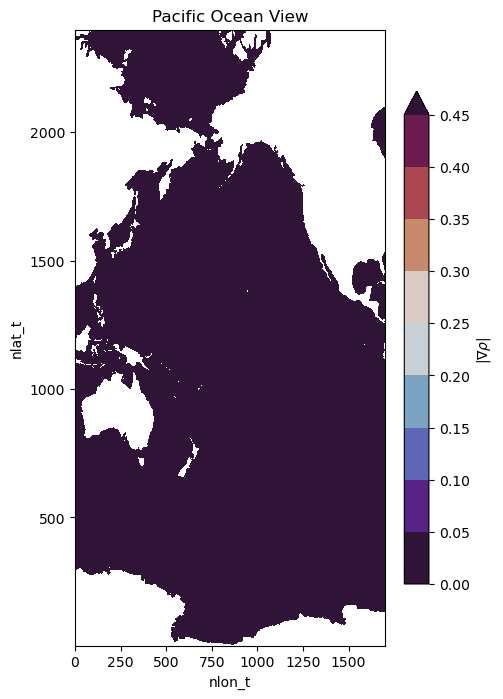

In [39]:
#PAC ocean
fig, ax = plt.subplots(figsize=(5,8))
pac_roll = (modgradrho*1e3).roll(nlon_t=2400, roll_coords=True).isel(nlon_t=slice(1000,2700))
t = pac_roll.mean('time').drop('nlon_t').plot.contourf(levels=np.arange(0,0.5,0.05), 
                                                       cmap='twilight_shifted',
                                                       cbar_kwargs={'shrink':0.8, 
                                                                    'label':r'$|\nabla \rho|$'})
plt.title('Pacific Ocean View');

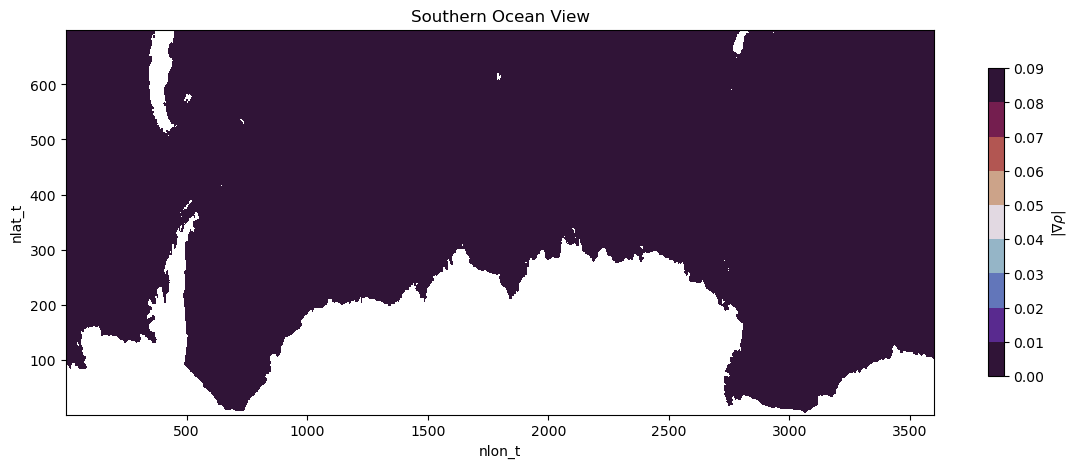

In [47]:
#SO ocean
fig, ax = plt.subplots(figsize=(14,5))
(modgradrho*1e3).isel(nlat_t=slice(0, 700)).mean('time').plot.contourf(levels=np.arange(0,0.1,0.01), 
                                                              cmap='twilight_shifted',
                                                              cbar_kwargs={'shrink':0.8, 
                                                                           'label':r'$|\nabla \rho|$'})
plt.title('Southern Ocean View');